# **6.8300 Project: AudioVisual Contrastive Learning w/ Augmentations**

This colab contains the model and the training loop for determining how effective contrastive learning w/ augmentations is for generating new representations for audio-visual data.

## 1. Perform Necessary Imports

In [ ]:
!pip install openl3
!pip install tqdm
!pip install av

In [ ]:
import torch
import torch.nn as nn
import torchvision.models.video as video_models
import openl3
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision.io import read_video
import torchaudio
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This code is to deal with memory issues with CUDA when running on T4 GPU

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import gc
gc.collect()
torch.cuda.empty_cache()

## 2. Projection and Encoder Models

We create a trainable projection head that we attach at the end of pretrained video and audio encoders. This projection heads maps the video and audio space into the same dimensional space. It consists of two linear layers with a ReLU activation function in it.

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )

    def forward(self, x):
        return self.net(x)

For the video encoder, we use the resnet 18 model from pytorch attached with the projection head at the end. Note that we don't want to finetune the encoder, so we freeze the resnet 18 weights.

In [ ]:
class VideoEncoder(nn.Module):
    def __init__(self, proj_dim=128, freeze_weights=True):
        super().__init__()
        base_model = video_models.r3d_18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # remove final FC
        self.proj_head = ProjectionHead(512, proj_dim)

        if freeze_weights:
          for param in self.feature_extractor.parameters():
              param.requires_grad = False

    def forward(self, x):  # (B, C, T, H, W)
        x = self.feature_extractor(x)  # (B, 512, 1, 1, 1)
        x = x.view(x.size(0), -1)
        return self.proj_head(x)

We do the same thing with the following audio encoder as the video encoder by attaching a projection head of the same dimensions at the end of the audio encoder. Note that since openL3 isn't part of pytorch, the forward function is significantly more complex.

In [ ]:
class OpenL3Encoder(nn.Module):
    def __init__(self, proj_dim=128, input_repr="mel256", content_type="music", embedding_size=512):
        super().__init__()
        self.sr = 48000
        self.model = openl3.models.load_audio_embedding_model(
            input_repr=input_repr,
            content_type=content_type,
            embedding_size=embedding_size
        )
        self.embedding_size = embedding_size
        self.proj_head = ProjectionHead(embedding_size, proj_dim)

    def forward(self, x): # x can be a LIST of tensors OR a single BATCH TENSOR
        embeddings = []

        # --- Determine input type and batch size ---
        is_list_input = isinstance(x, list)
        if is_list_input:
            batch_size = len(x)
            if batch_size == 0: # Handle empty list case
                 device = self.proj_head.net[0].weight.device
                 empty_proj_input = torch.empty(0, self.embedding_size).to(device)
                 return self.proj_head(empty_proj_input)
            # Get device from first tensor in list
            device = x[0].device
        elif isinstance(x, torch.Tensor):
            batch_size = x.size(0)
            if batch_size == 0: # Handle empty tensor case
                 device = self.proj_head.net[0].weight.device
                 empty_proj_input = torch.empty(0, self.embedding_size).to(device)
                 return self.proj_head(empty_proj_input)
            device = x.device # Get device from the tensor itself
        else:
            raise TypeError(f"OpenL3Encoder expects input as list or tensor, got {type(x)}")


        # --- Process each audio sample ---
        for i in range(batch_size):
            if is_list_input:
                audio_tensor = x[i] # Get the i-th tensor from the list
            else:
                audio_tensor = x[i, :] # Get the i-th slice from the batch tensor

            # Ensure tensor is 1D numpy array for openl3
            # Squeeze potentially removes channel dim if present (e.g., [1, L] -> [L])
            audio_np = audio_tensor.squeeze().detach().cpu().numpy()

            # Check dimensions and emptiness *before* calling openl3
            if audio_np.ndim != 1:
                print(f"Warning: Audio sample {i} has unexpected shape {audio_np.shape} before openl3. Skipping.")
                # Append a placeholder embedding matching the expected device and size
                emb_mean = torch.zeros(self.embedding_size, device=device).float()
            elif audio_np.size == 0:
                 print(f"Warning: Audio sample {i} is empty before openl3. Skipping.")
                 emb_mean = torch.zeros(self.embedding_size, device=device).float()
            else:
                try:
                    # Process with OpenL3 using the correct model attribute name
                    emb, _ = openl3.get_audio_embedding(audio_np, self.sr, model=self.model, center=True)
                    # Aggregate embeddings and move to the correct device
                    emb_mean = torch.tensor(emb.mean(axis=0), device=device).float()
                    # Optional: Check if emb_mean size is correct
                    if emb_mean.shape[0] != self.embedding_size:
                        print(f"Warning: OpenL3 output embedding size mismatch for sample {i}. Got {emb_mean.shape[0]}, expected {self.embedding_size}. Using zeros.")
                        emb_mean = torch.zeros(self.embedding_size, device=device).float()

                except Exception as e:
                    print(f"Error during openl3.get_audio_embedding for sample {i}: {e}. Using zeros.")
                    import traceback
                    traceback.print_exc() # Print error details
                    emb_mean = torch.zeros(self.embedding_size, device=device).float()


            embeddings.append(emb_mean)

        # Stack embeddings for the batch - should now have 'batch_size' embeddings
        if not embeddings: # Should not happen if batch_size > 0, but as safety check
             print("Warning: Embeddings list is empty before stacking.")
             empty_proj_input = torch.empty(0, self.embedding_size).to(device)
             return self.proj_head(empty_proj_input)

        embeddings_batch = torch.stack(embeddings)  # Shape: (batch_size, embedding_size)

        # Apply the PyTorch projection head
        projected_embeddings = self.proj_head(embeddings_batch)

        return projected_embeddings

## 3. Generate the Contrastive Model and Loss

We can now combine the video and audio encoders along with a classifier model to test how well our learned representations are.

In [ ]:
class AVContrastiveModel(nn.Module):
    def __init__(self, proj_dim=128, num_classes=10):  # Add num_classes
        super().__init__()
        self.video_encoder = VideoEncoder(proj_dim)
        self.audio_encoder = OpenL3Encoder(proj_dim)
        self.classifier = nn.Linear(proj_dim * 2, num_classes)  # Classification head

    def forward(self, video, audio):
        z_video = self.video_encoder(video)
        z_audio = self.audio_encoder(audio)
        z = torch.cat([z_video, z_audio], dim=1)  # Concatenate features
        logits = self.classifier(z)  # Get classification logits
        return z_video, z_audio, logits  # Return embeddings and logits

We generate a contrastive loss function using cross entropy. It takes in the video embedding and then the audio embedding and creates a similarity matrix.

In [ ]:
def contrastive_loss(z1, z2, temperature=0.07):
    # z1, z2 shapes: (B, D)
    B = z1.size(0)
    D = z1.size(1)

    # Normalize features
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    # Concatenate features: Video embeddings first, then Audio embeddings
    z = torch.cat([z1, z2], dim=0)  # Shape: (2B, D)

    # Calculate pairwise cosine similarity
    # sim[i, j] = similarity between z[i] and z[j]
    sim = torch.matmul(z, z.T)  # Shape: (2B, 2B)

    # --- REMOVE MASKING AND RESHAPING ---
    # mask = ~torch.eye(2 * B, dtype=bool, device=z.device)
    # logits = sim[mask].view(2 * B, -1) / temperature # Incorrect shape (2B, 2B-1)
    # --- FIX: Use the full similarity matrix ---
    logits = sim / temperature # Shape: (2B, 2B)

    # Create targets:
    # For the first B rows (videos z1), the positive match is the corresponding audio (z2) at index i+B
    # For the second B rows (audios z2), the positive match is the corresponding video (z1) at index i
    targets_arange = torch.arange(B, device=z.device)
    # Targets for rows 0 to B-1 should be B to 2B-1
    # Targets for rows B to 2B-1 should be 0 to B-1
    targets = torch.cat([targets_arange + B, targets_arange]) # Shape: (2B,) Correct indices for (2B, 2B) logits

    # Calculate cross-entropy loss
    # logits shape (2B, 2B), targets shape (2B,) with values in [0, 2B-1]
    return F.cross_entropy(logits, targets)


We add a constrastive loss function that includes masking just in case.

In [ ]:
def contrastive_loss_with_masking(z1, z2, temperature=0.07):
    # z1, z2 shapes: (B, D)
    B = z1.size(0)

    # Normalize features to unit length (cosine similarity)
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    # Concatenate video and audio features
    z = torch.cat([z1, z2], dim=0)  # Shape: (2B, D)

    # Compute pairwise similarity matrix (cosine sim / temperature)
    sim = torch.matmul(z, z.T) / temperature  # Shape: (2B, 2B)

    # Mask self-similarity (prevent matching an embedding with itself)
    mask = torch.eye(2 * B, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)  # Assign large negative value so softmax ~ 0

    # Construct targets:
    # Positives are at positions: [i → i+B] and [i+B → i]
    targets = torch.arange(B, device=z.device)
    targets = torch.cat([targets + B, targets])  # Shape: (2B,)

    # Cross-entropy loss over rows
    return F.cross_entropy(sim, targets)

## 4. Generate Dataset

To consolidate the dataset, we will create a class that loads the augmented video and audio data stored in the root_dir (the original data) and aud_dir (the augmented data).

Something interesting to note: In the getitem dunder method, the dataset only takes the first num_frames = 16 frames of the video. If the video doesn't have enough frames, it repeats the video. This is necessary to keep the size of the videos consistent.

In [ ]:
class AVContrastiveDataset(Dataset):
    def __init__(
        self,
        root_dir="/content/drive/MyDrive/clipped_data",      # Original data structure (for finding samples)
        aug_root="/content/drive/MyDrive/augmented_data",    # Root for augmented files
        video_aug_dirs=["crop_color", "crop_sobel"], # Subdirs under aug_root
        audio_aug_dirs=["bg_noise", "drc"],          # Subdirs under aug_root
        num_frames=16,
        video_size=(112, 112),
        audio_sr=48000,
        samples_list=None
    ):
        self.root = Path(root_dir)
        self.aug_root = Path(aug_root)
        self.video_aug_dirs = video_aug_dirs
        self.audio_aug_dirs = audio_aug_dirs
        self.num_frames = num_frames
        self.video_size = video_size
        self.audio_sr = audio_sr
        self.samples = []

        if samples_list is not None:
            print(f"Initializing dataset with provided list of {len(samples_list)} samples.")
            self.samples = samples_list
            # Need to determine classes and class_to_idx from the provided list
            # Assuming samples_list contains tuples like (class_name, base_name)
            if self.samples:
                 self.classes = sorted(list(set(s[0] for s in self.samples)))
            else:
                 self.classes = []
            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        else:

            # Collect all .mp4 files under class folders in the ORIGINAL directory
            self.samples = []
            # Ensure root directory exists
            if not self.root.is_dir():
                raise FileNotFoundError(f"Root directory '{self.root}' not found.")

            # Change this!
            self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])[:5]
            if not self.classes:
                print(f"Warning: No class subdirectories found in '{self.root}'. Dataset will be empty.")

            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

            for cls in self.classes:
                class_path = self.root / cls
                if not class_path.is_dir():
                    print(f"Warning: Expected directory, but found file: {class_path}")
                    continue
                found_files = False
                for video_path in class_path.glob("*.mp4"):
                    base_name = video_path.stem
                    self.samples.append((cls, base_name)) # Store class and base filename
                    found_files = True
                if not found_files:
                    print(f"Warning: No .mp4 files found in class directory: {class_path}")

        if not self.samples:
             print(f"Warning: No samples collected. Check '{self.root}' structure and content.")


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Retrieve the class name (e.g., 'violin') and base filename (e.g., 'video_001')
        cls, base = self.samples[idx]
        label = self.class_to_idx[cls]

        # Choose random augmentations
        video_aug = random.choice(self.video_aug_dirs)
        audio_aug = random.choice(self.audio_aug_dirs)

        # --- CORRECTED PATH CONSTRUCTION ---
        # Assumes structure: augmented_data/<aug_type>/<class>/<base_name>.mp4
        video_path = self.aug_root / video_aug / cls / f"{base}.mp4"
        audio_path = self.aug_root / audio_aug / cls / f"{base}.wav"
        # --- END CORRECTION ---

        try:
            # Load video
            video, _, _ = read_video(str(video_path), pts_unit="sec")

            # Check for empty video immediately after loading
            if video.nelement() == 0:
                print(f"WARNING: Loaded video tensor is empty for {video_path}!")
                # Decide how to handle: skip, raise error, return dummy?
                # For now, raising an error is safest to alert you.
                raise RuntimeError(f"Video file {video_path} loaded with 0 frames or elements.")

            video = video.permute(0, 3, 1, 2).float() / 255.0  # T x C x H x W

            T_total = video.size(0)

            # Explicitly check for T_total <= 0 before division/modulo
            if T_total <= 0:
                 raise RuntimeError(f"Video file {video_path} resulted in T_total={T_total} after permute.")

            # Resize and crop video frames
            if T_total > self.num_frames:
                start = random.randint(0, T_total - self.num_frames)
                video = video[start : start + self.num_frames]
            else:
                # Now T_total > 0 is guaranteed here
                repeat = (self.num_frames + T_total - 1) // T_total
                video = video.repeat((repeat, 1, 1, 1))[:self.num_frames]

            video = torch.nn.functional.interpolate(video, size=self.video_size, mode='bilinear', align_corners=False) # Added align_corners=False often recommended
            video = video.permute(1, 0, 2, 3)  # → C x T x H x W

            # Load and resample audio
            waveform, sr = torchaudio.load(str(audio_path))
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)  # Mono
            if sr != self.audio_sr:
                resampler = torchaudio.transforms.Resample(sr, self.audio_sr)
                waveform = resampler(waveform)
            # Ensure waveform is 1D (B, L) -> (L) for OpenL3 later? Check model input.
            # The OpenL3Encoder seems to handle batching internally by iterating,
            # so returning individual waveforms might be correct.
            # waveform = waveform.squeeze(0) # If needed

        except FileNotFoundError:
             print(f"ERROR: File not found at path: {video_path} or {audio_path}")
             # Depending on desired behavior, you might want to return None
             # and handle it in the DataLoader's collate_fn, or raise the error.
             raise # Re-raise the error for now
        except Exception as e:
            print(f"ERROR processing sample idx {idx} (cls='{cls}', base='{base}') at path {video_path} / {audio_path}: {e}")
            raise # Re-raise the error

        return video, waveform.squeeze(0), label # Return waveform likely needs to be (L,) not (1, L)

In [ ]:
@torch.no_grad()
def evaluate_retrieval(model, val_dataloader, device):
    model.eval()

    all_z_video = []
    all_z_audio = []
    batch_count = 0
    processed_count = 0

    print(f"--- Starting Evaluation on {len(val_dataloader)} batches ---")
    for batch_idx, batch_data in enumerate(val_dataloader):
        batch_count += 1

        # --- 1. Check initial batch data ---
        try:
            if not isinstance(batch_data, (list, tuple)) or len(batch_data) < 2:
                 continue
            video, audio, _ = batch_data

            # --- MODIFY CHECKS TO HANDLE TENSOR OR LIST ---
            is_audio_list = isinstance(audio, list)

            if not isinstance(video, torch.Tensor):
                continue
            if video.nelement() == 0:
                 continue

            if is_audio_list:
                if not audio: # Check if list itself is empty
                    continue
                # Filter empty tensors within the list
                original_audio_count = len(audio)
                audio = [a for a in audio if a.nelement() > 0]
                filtered_audio_count = len(audio)
                if not audio: # Check if list became empty after filtering
                     continue
            elif isinstance(audio, torch.Tensor):
                 if audio.nelement() == 0:
                      continue
                 # Audio is a valid tensor, no filtering needed like list case
            else:
                  continue

        except Exception as e:
            continue

        # --- 2. Move to device ---
        try:
            video = video.to(device)
            if is_audio_list:
                 audio = [a.to(device) for a in audio] # Move items in list
            else:
                 audio = audio.to(device) # Move the tensor
        except Exception as e:
             continue

        # --- 3. Final check before model ---
        if video.shape[0] == 0: # Should be caught earlier, but double check
            continue
        # Note: video.shape[0] might not equal len(audio) here if filtering happened!
        # The model's forward pass MUST handle this if contrastive loss expects aligned pairs.
        # Let's assume the model handles it or we only care about evaluating available pairs.

        # --- 4. Model Forward Pass ---
        try:
             z_video, z_audio = model(video, audio)
             if isinstance(z_video, torch.Tensor): print(f"  DEBUG: Model output video shape: {z_video.shape}")
             if isinstance(z_audio, torch.Tensor): print(f"  DEBUG: Model output audio shape: {z_audio.shape}")


             # --- 5. Check Model Output ---
             if not isinstance(z_video, torch.Tensor) or not isinstance(z_audio, torch.Tensor):
                 print("  DEBUG: Skipping - Model output types are not both tensors.")
                 continue
             # Check for empty embeddings
             if z_video.nelement() == 0 or z_audio.nelement() == 0:
                 print("  DEBUG: Skipping - Model produced empty embeddings.")
                 continue
             # Check for matching batch sizes *after* model forward pass
             # This assumes your model should output aligned embeddings for the batch
             if z_video.shape[0] != z_audio.shape[0]:
                 print(f"  DEBUG: Skipping - Model output batch sizes mismatch: {z_video.shape[0]} vs {z_audio.shape[0]}.")
                 continue
             if z_video.shape[0] == 0: # Check if batch dim is 0 after model
                  print("  DEBUG: Skipping - Model output batch dimension is 0.")
                  continue


        except Exception as e:
             # Print the actual error during forward pass
             import traceback
             traceback.print_exc() # Print detailed traceback for the forward pass error
             continue


        # --- 6. Append successful embeddings ---
        all_z_video.append(z_video.cpu()) # Move to CPU to avoid GPU memory buildup
        all_z_audio.append(z_audio.cpu())
        processed_count += 1

    # --- Calculations (Only if embeddings were collected) ---
    if not all_z_video or not all_z_audio: # Check if lists are still empty
        # It's important to set model back to train mode even if eval failed
        model.train()
        return 0.0, 0.0 # Return default values

    # Concatenate all embeddings
    try:
        all_z_video = torch.cat(all_z_video, dim=0)
        all_z_audio = torch.cat(all_z_audio, dim=0)
        N_val = all_z_video.size(0)
    except Exception as e:
        model.train()
        return 0.0, 0.0

    if N_val == 0:
         model.train()
         return 0.0, 0.0

    # Normalize embeddings (important for cosine similarity via dot product)
    all_z_video = F.normalize(all_z_video, dim=1)
    all_z_audio = F.normalize(all_z_audio, dim=1)

    # Calculate the N_val x N_val similarity matrix
    sim_matrix = torch.matmul(all_z_video, all_z_audio.T) # Video queries x Audio database

    # Ground truth: diagonal elements should be the highest similarity
    # Create target labels (indices 0 to N_val-1)
    targets = torch.arange(N_val)

    # --- Video to Audio Retrieval (Rows) ---
    # Find the index of the highest similarity for each video query (each row)
    v2a_preds = torch.argmax(sim_matrix, dim=1)
    v2a_correct = (v2a_preds == targets)
    v2a_r1 = v2a_correct.float().mean().item() * 100.0 # Recall@1 as percentage

    # --- Audio to Video Retrieval (Columns) ---
    # Find the index of the highest similarity for each audio query (each column)
    a2v_preds = torch.argmax(sim_matrix, dim=0) # Find max index in each column
    a2v_correct = (a2v_preds == targets)
    a2v_r1 = a2v_correct.float().mean().item() * 100.0 # Recall@1 as percentage

    print(f"V->A R@1: {v2a_r1:.2f}%, A->V R@1: {a2v_r1:.2f}%")
    model.train() # Set model back to training mode
    return v2a_r1, a2v_r1

##5. Constrastive Learning Training Loop

We will now train the projection heads attached to the encoders. Note that even though the classification model is part of the model, it never actually gets trained in this step, intentionally. This is because when the model is called, the forward pass returns the video and audio embeddings as well as the output of the classification model. However, the backpropagation is done using the contrastive loss which only uses the embeddings and not the classification.

In [ ]:
# Assume all model components are defined:
# - AVContrastiveModel
# - contrastive_loss
# - AVContrastiveDataset

# --- Data Loading and Splitting ---
print("Loading and splitting data...")
# 1. Load all samples first (modify dataset __init__ or do it here)
full_dataset_reader = AVContrastiveDataset() # Needs access to self.samples
all_samples = full_dataset_reader.samples
all_classes = full_dataset_reader.classes
num_classes = len(all_classes)

train_samples, val_samples = train_test_split(all_samples, test_size=0.3, random_state=42) # Use random_state for reproducibility
print(f"Total samples: {len(all_samples)}, Train: {len(train_samples)}, Val: {len(val_samples)}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = AVContrastiveModel(proj_dim=128, num_classes=num_classes).to(device) # Pass num_classes
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Dataset and DataLoader
train_dataset = AVContrastiveDataset(samples_list=train_samples) # Pass train samples
val_dataset = AVContrastiveDataset(samples_list=val_samples)     # Pass val samples


train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0) # Larger batch size for eval usually okay

# Training loop
num_epochs = 5
epoch_losses = []
epoch_v2a_r1 = [] # for storing contrastive loss
epoch_a2v_r1 = [] # for storing classification loss
epoch_classification_accuracy = []

for epoch in range(num_epochs):
    model.train()
    total_contrastive_loss = 0 # for storing contrastive loss
    processed_batches = 0

    for i, (video, audio, labels) in enumerate(train_dataloader):
        # video: (B, C, T, H, W), audio: (B, L)
        video = video.to(device)
        audio = [a.to(device) for a in audio]  # individual waveforms (already variable length)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        z_video, z_audio, logits = model(video, audio)  # OpenL3 handles audio per-sample
        contrastive_loss = contrastive_loss_with_masking(z_video, z_audio)  # Calculate contrastive loss

        # Backward and optimize using contrastive loss only
        contrastive_loss.backward()
        optimizer.step()

        # Accumulate losses
        total_contrastive_loss += contrastive_loss.item()

        # Calculate accuracy (for evaluation only)
        _, predicted = torch.max(logits, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        print(f"[Epoch {epoch+1}] Step {i}/{len(train_dataloader)} - Contrastive Loss: {contrastive_loss.item():.4f}")

        processed_batches += 1

    # --- End of Epoch Evaluation ---
    if processed_batches > 0:
        avg_contrastive_loss = total_contrastive_loss / processed_batches
        epoch_losses.append(avg_contrastive_loss) # store contrastive loss
        epoch_v2a_r1.append(avg_contrastive_loss) # store contrastive loss
        print(f"--- [Epoch {epoch+1}/{num_epochs}] Avg Training Contrastive Loss: {avg_contrastive_loss:.4f},  ---")
    else:
        epoch_losses.append(float('nan'))
        print(f"--- [Epoch {epoch+1}/{num_epochs}] No batches processed in training ---")

    # Call evaluation function
    if len(val_dataloader) > 0: # Check if validation set is not empty
        val_accuracy = evaluate_classification(model, val_dataloader, device)
        epoch_classification_accuracy.append(val_accuracy)
    else:
        print("Skipping evaluation as validation dataloader is empty.")
        epoch_classification_accuracy.append(0.0) # Append default values if no eval


print("Training finished.")

# --- Plotting ---
print("Generating plots...")
fig, ax = plt.subplots(figsize=(20, 5)) # Create 3 subplots

# Plot Contrastive Loss
plot_epochs_loss = [i + 1 for i, loss in enumerate(epoch_losses) if not torch.isnan(torch.tensor(loss))]
plot_losses = [loss for loss in epoch_losses if not torch.isnan(torch.tensor(loss))]
if plot_epochs_loss:
    ax.plot(plot_epochs_loss, plot_losses, marker='o', linestyle='-')
    ax.set_title('Average Contrastive Training Loss per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Contrastive Loss')
    ax.set_xticks(plot_epochs_loss)
    ax.grid(True)


plt.tight_layout()
plt.show()
print("Plots displayed.")

## 6. Benchmark using Classification

We create an evaluate function that determines the accuract of the classification model. We then run a training loop that trains the classification model using the representation learned by the contrastive learning.

In [ ]:
@torch.no_grad()
def evaluate_classification(model, val_dataloader, device):
    model.eval()
    correct = 0
    total = 0

    for video, audio, labels in val_dataloader:
        video = video.to(device)
        audio = [a.to(device) for a in audio]
        labels = labels.to(device)

        _, _, logits = model(video, audio)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")
    model.train()
    return accuracy

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━

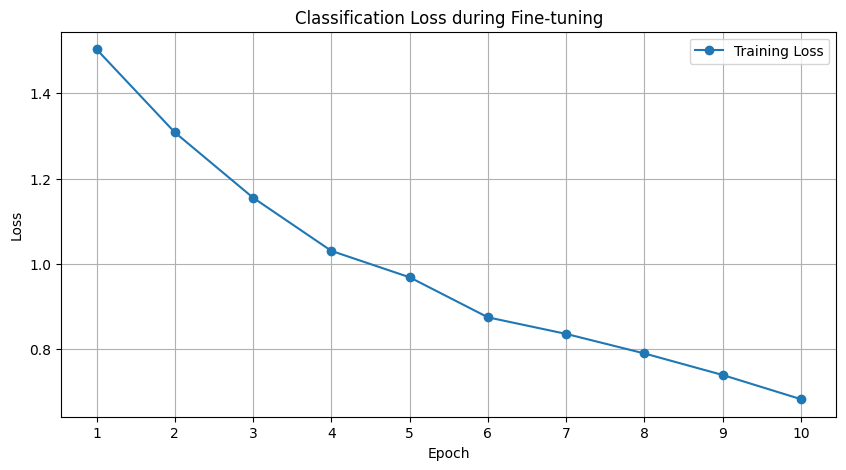

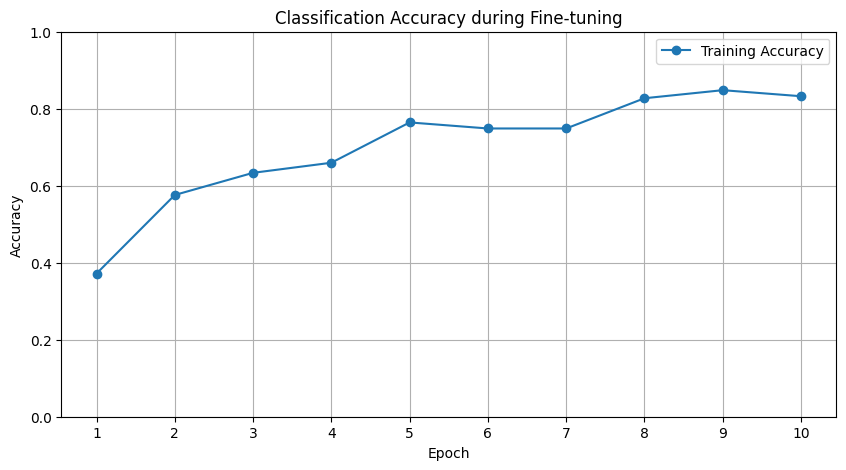

In [ ]:
# ... (Your existing code for model definition, dataset, dataloaders) ...

# --- Fine-tuning the Classification Head ---

# 1. Freeze feature extractors
for param in model.video_encoder.parameters():
    param.requires_grad = False
for param in model.audio_encoder.parameters():
    param.requires_grad = False

# 2. Adjust optimizer
optimizer_classifier = optim.AdamW(model.classifier.parameters(), lr=1e-3)

# 3. Fine-tuning loop and plotting
num_fine_tune_epochs = 10
fine_tune_losses = []
fine_tune_accuracies = []

for epoch in range(num_fine_tune_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0

    for video, audio, labels in train_dataloader:
        video = video.to(device)
        audio = [a.to(device) for a in audio]
        labels = labels.to(device)

        optimizer_classifier.zero_grad()
        _, _, logits = model(video, audio)
        classification_loss = F.cross_entropy(logits, labels)

        classification_loss.backward()
        optimizer_classifier.step()

        epoch_loss += classification_loss.item()
        _, predicted = torch.max(logits, 1)
        epoch_total += labels.size(0)
        epoch_correct += (predicted == labels).sum().item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    avg_epoch_accuracy = epoch_correct / epoch_total

    fine_tune_losses.append(avg_epoch_loss)
    fine_tune_accuracies.append(avg_epoch_accuracy)

    print(f"Fine-tuning Epoch [{epoch+1}/{num_fine_tune_epochs}] - Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    # Evaluate on validation set after each fine-tuning epoch
    val_accuracy = evaluate_classification(model, val_dataloader, device)
    fine_tune_accuracies.append(val_accuracy)

print("Fine-tuning finished.")

# --- Plotting ---
import matplotlib.pyplot as plt

epochs_range = range(1, num_fine_tune_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, fine_tune_losses, marker='o', linestyle='-', label='Training Loss')
plt.title('Classification Loss during Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, fine_tune_accuracies[::2], marker='o', linestyle='-', label='Training Accuracy')
plt.title('Classification Accuracy during Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

Save the weights of the contrastive model to the drive

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '/content/drive/MyDrive/my_audio_visual_model.pth')
print("Model weights saved successfully!")